In [1]:
import os
import datetime
import pandas as pd
import numpy as np

from keras.initializers import he_uniform
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

seed=11
np.random.seed(seed)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 0. Preps

In [2]:
def sample_random_predictions(X, y, sample_size=3):
    I = np.random.permutation(X.shape[0])[:sample_size]

    
    for c, i in enumerate(I):
        img = X[i].reshape(28, 28)
        plt.subplot(131+c)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(y[i])

In [3]:
def print_training_history(history):
    acc_list = history.history['acc']
    acc = acc_list[-1]
    best_acc_index = np.array(acc_list).argmax()
    best_acc = acc_list[best_acc_index]
    
    print('Accuracy: {:.4f} \tBest Accuracy: {:.4f} \t\t@ {} epoch'.format(acc, best_acc, best_acc_index+1))
    
    if 'val_acc' in  history.history.keys():
        val_acc_list = history.history['val_acc']
        val_acc = val_acc_list[-1]
        best_val_acc_index = np.array(val_acc_list).argmax()
        best_val_acc = val_acc_list[best_val_acc_index]
        print('Dev Accuracy: {:.4f} \tBest Dev Accuracy: {:.4f} \t@ {} epoch'.format(val_acc, best_val_acc, best_val_acc_index+1))
    

In [4]:
def plot_training_history(history):
    plt.figure(figsize=(15,4))

    plt.subplot(121)
    plt.plot(history.history['acc'], label='Training Set')
    
    if 'val_acc' in history.history.keys():
        plt.plot(history.history['val_acc'], label='Validation Set')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(122)
    plt.plot(history.history['loss'], label='Training Set')
    
    if 'val_loss' in history.history.keys():
        plt.plot(history.history['val_loss'], label='Validation Set')
    plt.title('Loss vs Epochs')
    plt.xlabel('Loss')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

In [5]:
def plot_error_matrix(cm):
    row_sum = cm.sum(axis=1, keepdims=True)
    norm_cm = cm/row_sum
    
    np.fill_diagonal(norm_cm, 0)
    sns.heatmap(norm_cm, robust=True, fmt="f", cmap='RdBu_r', vmin=0, vmax=4)

    plt.show()

## 1. Getting Data

In [6]:
payload_dir = '../payload/'
payload_file = 'normal-payload.npz'

payload_path = os.path.join(payload_dir, payload_file)

payload_archive = np.load(payload_path)

dev_set = payload_archive['dev_set']
test_set = payload_archive['test_set']
train_dev_set = payload_archive['train_dev_set']
train_set = payload_archive['train_set']

1.1 Training Set

In [7]:
trainX, trainy = train_set[:,1:].reshape(-1,28,28,1), train_set[:,0]
trainY = np_utils.to_categorical(trainy)

In [8]:
train_devX, train_devy = train_dev_set[:,1:].reshape(-1,28,28,1), train_dev_set[:,0]
train_devY = np_utils.to_categorical(train_devy)

In [9]:
testX, testy = test_set[:,1:].reshape(-1,28,28,1), test_set[:,0]
testY = np_utils.to_categorical(testy)

In [10]:
devX, devy = dev_set[:,1:].reshape(-1,28,28,1), dev_set[:,0]
devY = np_utils.to_categorical(devy)

## 5. Error Analysis

In [18]:
models_dir = '../models'

convnet_dir = os.path.join(models_dir, 'ConvNets')
mlp_dir = os.path.join(models_dir, 'MLPNet')

cnet1_path = os.path.join(convnet_dir, 'ConvNet.01-0.02.hdf5')
cnet2_path = os.path.join(convnet_dir, 'ConvNet.0.02.hdf5')

mlp1_path = os.path.join(mlp_dir, 'MLPNet.61-0.06.hdf5')
mlp2_path = os.path.join(mlp_dir, 'MLPNet.44-0.09.hdf5')

In [22]:
conv_model_1 = load_model(cnet1_path)
conv_model_2 = load_model(cnet2_path)

mlp_model_1 = load_model(mlp1_path)
mlp_model_2 = load_model(mlp2_path)

In [44]:
models = [conv_model_1, conv_model_2]

In [20]:
def pred_error(pred,y):
    return np.sum(pred!=y)/len(y)*100

In [21]:
def plot_err(pred, y):
    cm=confusion_matrix(y_pred=pred, y_true=y)
    row_sum = np.sum(cm, axis=1, keepdims=True)
    err_matrix = cm/row_sum
    
    np.fill_diagonal(err_matrix, 0)
    sns.heatmap(err_matrix, vmin=0, vmax=1e-2)

In [35]:
train_pred = np.ndarray((len(train_set), len(models)))
train_dev_pred = np.ndarray((len(train_dev_set), len(models)))
dev_pred = np.ndarray((len(dev_set), len(models)))
test_pred = np.ndarray((len(test_set), len(models)))

In [40]:
np.ravel(test_set).shape

(4945500,)

In [48]:
for i,dev_model in enumerate(models):
    
    print('Predictions by model',i+1,'/',len(models))
    print('-'*30)
    
    print('training set', end='')
    train_pred[:, i] = dev_model.predict_classes(trainX)
    print('....ok')
    
    print('training dev set', end='')
    train_dev_pred[:, i] = dev_model.predict_classes(train_devX)
    print('....ok')
    
    print('dev set', end='')
    dev_pred[:, i] = dev_model.predict_classes(devX)
    print('....ok')
    
    print('test set', end='')
    test_pred[:, i] = dev_model.predict_classes(testX)
    print('....ok')
    print('-*-'*10)
    print()
    

Predictions by model 1 / 2
------------------------------
training set....ok
training dev set....ok
dev set....ok
test set....ok
-*--*--*--*--*--*--*--*--*--*-

Predictions by model 2 / 2
------------------------------
training set....ok
training dev set....ok
dev set....ok
test set....ok
-*--*--*--*--*--*--*--*--*--*-



In [67]:
def error_ana(pred_results):
    train_pred, train_dev_pred, dev_pred, test_pred = pred_results
    
    f=plt.figure(figsize=(12,9))
    f.title
    
    plt.subplot(221)
    plt.title('training set')
    train_err = pred_error(train_pred, trainy)
    plot_err(train_pred, trainy)

    plt.subplot(222)
    plt.title('training-dev set')
    train_dev_err = pred_error(train_dev_pred, train_devy)
    plot_err(train_dev_pred, train_devy)

    plt.subplot(223)
    plt.title('dev set')
    dev_err = pred_error(devX, devy)
    plot_err(dev_pred, devy)

    plt.subplot(224)
    plt.title('test set')
    test_err = pred_error(testX, testy)
    plot_err(test_pred, testy)

    print('Human Level Error:\t~{:.2f} %'.format(0.00))
    print('Training Error:\t\t {:.2f} %'.format(train_err))
    print('Training-Dev Error:\t {:.2f} %'.format(train_dev_err))
    print('Dev Error:\t\t {:.2f} %'.format(dev_err))
    print('Test Error:\t\t {:.2f} %'.format(test_err))

In [68]:
for i in range(len(models)):
    print('Model:',i+1)
    print()
    model_preds = (train_pred[:,i], train_dev_pred[:,i], dev_pred[:,i], test_pred[:,i])
    error_ana(model_preds)

Model: 1



TypeError: __init__() got an unexpected keyword argument 'title'

#### 9 Errors

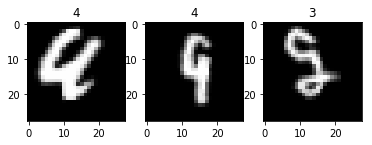

In [97]:
nine_i = np.where(train_devy==9)

train_dev9_y = train_devy[nine_i]
train_dev9pred = train_dev_pred[nine_i]
train_dev9X = train_devX[nine_i]
ind = np.where(train_dev9_y!=train_dev9pred)

evalX = train_dev9X[ind]
evaly = train_dev9pred[ind]

sample_random_predictions(evalX, evaly)